# Feed-forward coordinate prediction (DualOutput)

### Imports

In [1]:
# external
import pickle

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [2]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

### Preprocess data

In [3]:
data = oracle_reversed_data

train_data, test_data = preprocess.split_data(data, 0.8)

# preprocess trainingset
oracle_train_data = preprocess.ObtainDataset(train_data, "observations", "positions")
oracle_test_data = preprocess.ObtainDataset(test_data, "observations", "positions")

# build dataloader (tensor format)
batch_size = 128
dataset_loader_train_data = DataLoader(
    oracle_train_data, batch_size=batch_size, shuffle=True
)
dataset_loader_test_data = DataLoader(
    oracle_test_data, batch_size=batch_size, shuffle=True
)

### Initialize models

In [4]:
pred_coordinates = nets.DualOutput()
summary(pred_coordinates, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 1]              85
            Linear-8                  [-1, 120]          48,120
            Linear-9                   [-1, 84]          10,164
           Linear-10                    [-1, 1]              85
Total params: 119,610
Trainable params: 119,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.46
Estimated T

### Train model

Progress:   0%|          | 0/1000 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 459.4, Train Acc: 1.595 %,  Test Loss: 341.7, Test Acc: 1.674 %,
Epoch: 11, Train Loss: 96.21, Train Acc: 4.942 %,  Test Loss: 102.7, Test Acc: 4.498 %,
Epoch: 21, Train Loss: 96.0, Train Acc: 5.047 %,  Test Loss: 103.0, Test Acc: 2.197 %,
Epoch: 31, Train Loss: 94.35, Train Acc: 5.596 %,  Test Loss: 101.4, Test Acc: 7.218 %,
Epoch: 41, Train Loss: 93.99, Train Acc: 5.649 %,  Test Loss: 99.71, Test Acc: 1.674 %,
Epoch: 51, Train Loss: 92.74, Train Acc: 5.596 %,  Test Loss: 99.35, Test Acc: 1.569 %,
Epoch: 61, Train Loss: 91.81, Train Acc: 4.079 %,  Test Loss: 97.99, Test Acc: 5.858 %,
Epoch: 71, Train Loss: 91.27, Train Acc: 4.969 %,  Test Loss: 96.9, Test Acc: 5.649 %,
Epoch: 81, Train Loss: 90.61, Train Acc: 5.832 %,  Test Loss: 95.54, Test Acc: 5.962 %,
Epoch: 91, Train Loss: 89.15, Train Acc: 5.753 %,  Test Loss: 94.4, Test Acc: 4.498 %,
Epoch: 101, Train Loss: 88.46, Train Acc: 5.518 %,  Test Loss: 93.64, Test Acc: 2.72 %,
Epoch: 111, Train Loss: 87.35, Train

Epoch: 931, Train Loss: 53.34, Train Acc: 5.335 %,  Test Loss: 62.49, Test Acc: 6.172 %,
Epoch: 941, Train Loss: 53.55, Train Acc: 6.119 %,  Test Loss: 63.02, Test Acc: 5.021 %,
Epoch: 951, Train Loss: 53.25, Train Acc: 5.622 %,  Test Loss: 62.22, Test Acc: 5.858 %,
Epoch: 961, Train Loss: 53.19, Train Acc: 5.596 %,  Test Loss: 62.41, Test Acc: 5.439 %,
Epoch: 971, Train Loss: 53.44, Train Acc: 5.518 %,  Test Loss: 62.19, Test Acc: 5.23 %,
Epoch: 981, Train Loss: 53.13, Train Acc: 5.962 %,  Test Loss: 62.32, Test Acc: 4.812 %,
Epoch: 991, Train Loss: 53.06, Train Acc: 6.119 %,  Test Loss: 61.49, Test Acc: 5.021 %,
Finished Training


/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


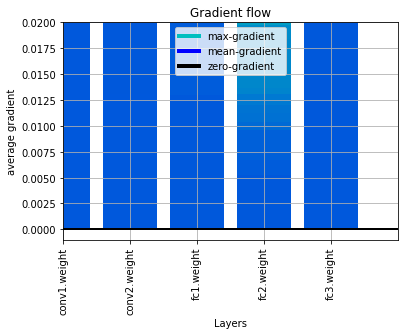

In [5]:
criterion = nn.MSELoss()  # CrossEntropyLoss
optimizer = optim.Adam(pred_coordinates.parameters(), lr=0.001)  # RMSprop, Adam, SGD

episodes = 1000
(
    pred_coordinates,
    train_loss,
    test_loss,
    train_acc,
    test_acc,
    train_dis,
    test_dis,
    train_dis_item,
    test_dis_item,
) = train.train_DualOutput(
    dataset_loader_train_data,
    dataset_loader_test_data,
    pred_coordinates,
    criterion,
    optimizer,
    episodes,
)

In [6]:
print(min(test_dis))

61.28833770751953


### Plot loss and accuracy curves

In [ ]:
plot.plot_losses(train_loss[10:], test_loss[10:])
plot.plot_acc(train_acc, test_acc, smooth=False)

### Plot distance over episodes

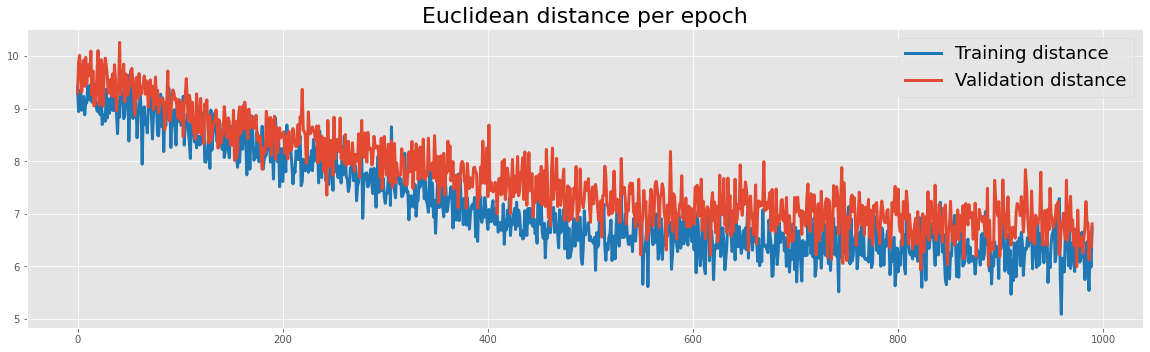

In [8]:
plot.plot_euclidean_distance(train_dis, test_dis)

### Histogram of the distribution shift (for test and training distances)

Training set 



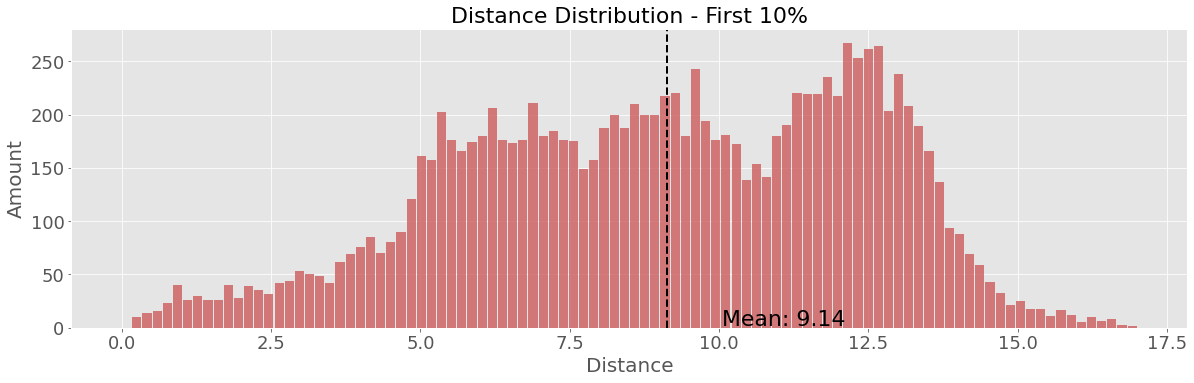

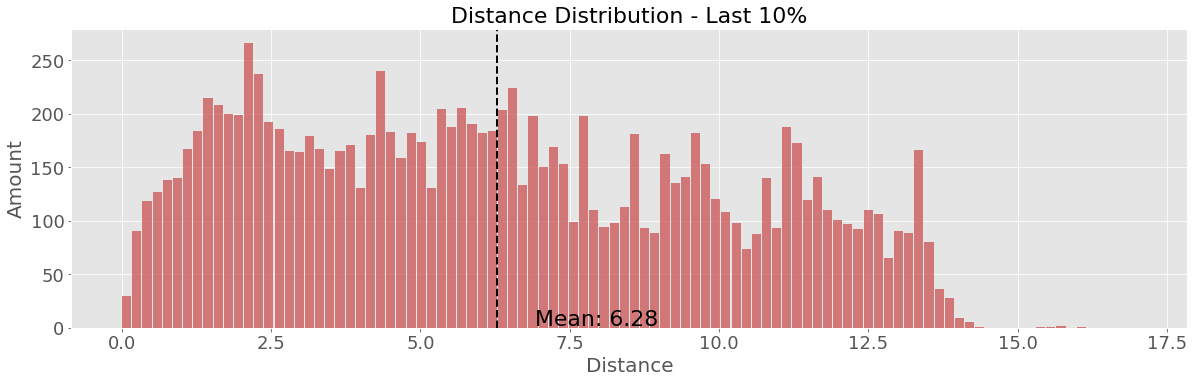

Validation set 



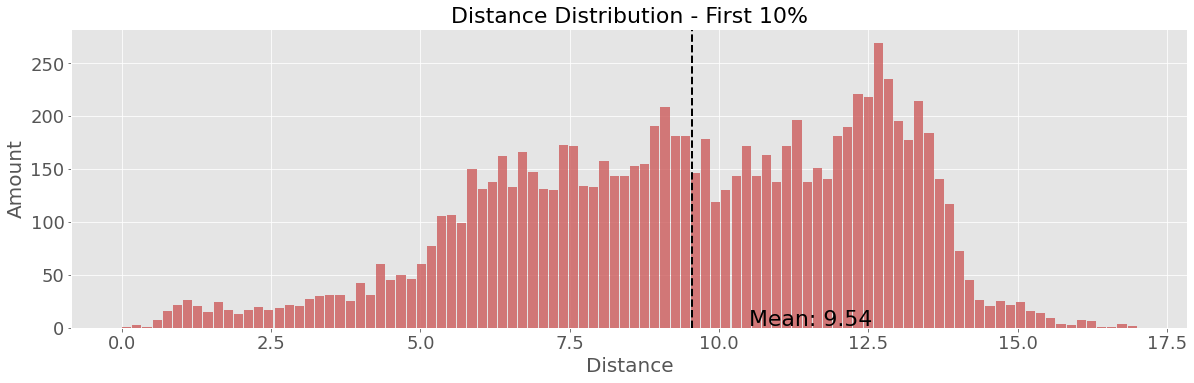

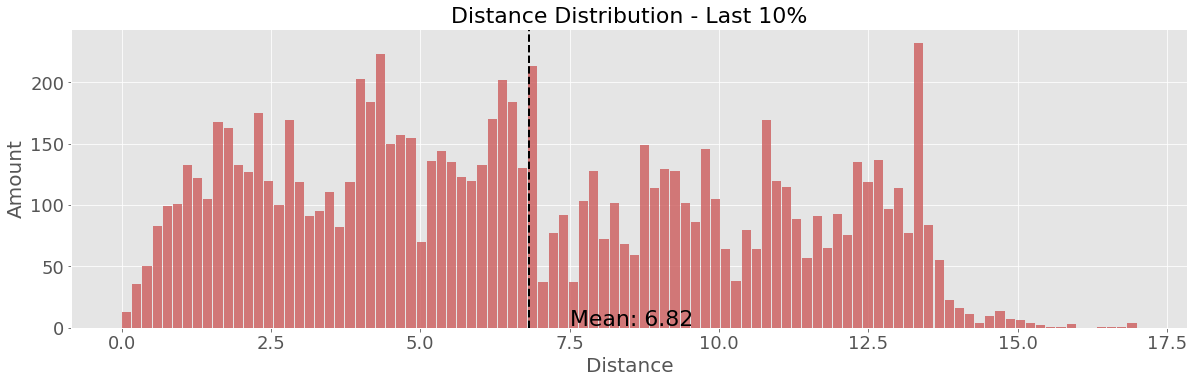

In [9]:
print("Training set \n")
plot.histo_distribution_shift(train_dis_item)
print("Validation set \n")
plot.histo_distribution_shift(test_dis_item)

### Save and load models

In [10]:
# save
torch.save(net, "models/DualOutput2.pt")

# load

NameError: name 'torch' is not defined